# Test: simple spherically symmetric stellar wind model
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from torch.optim          import Adam
from tqdm                 import tqdm
from astropy              import units, constants

from p3droslo.model       import TensorModel, SphericallySymmetric
from p3droslo.lines       import Line
from p3droslo.loss        import Loss, diff_loss

In [2]:
line = Line('CO', 2)

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


## Model
---

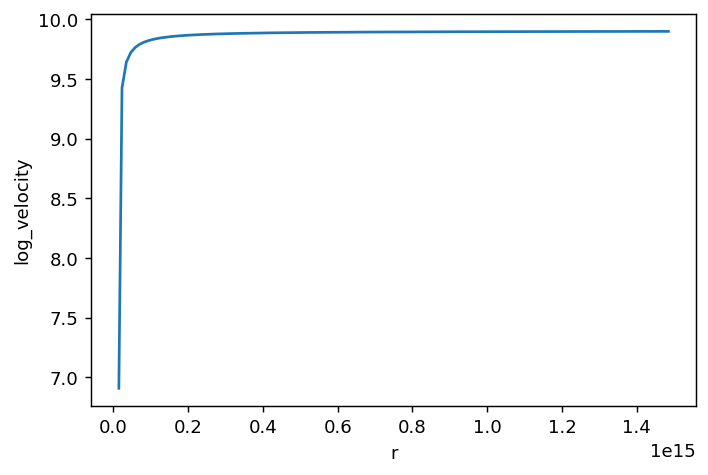

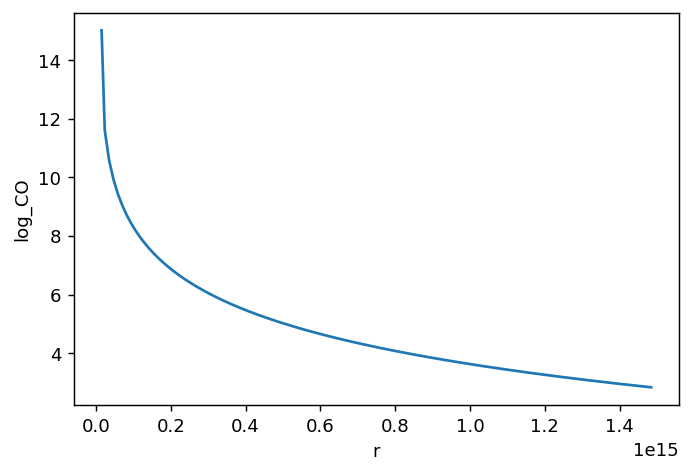

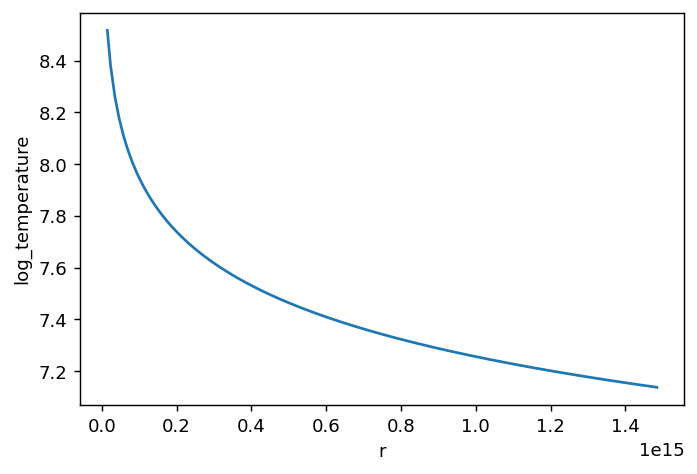

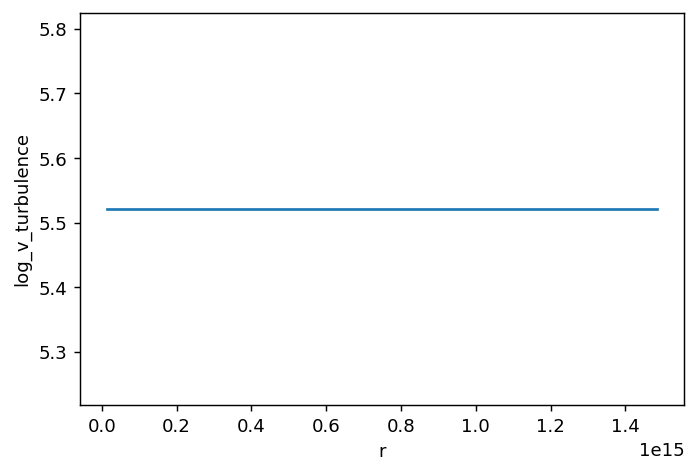

In [3]:
n_elements = 128

r_in  = (1.0e+2 * units.au).si.value
r_out = (1.0e+4 * units.au).si.value

v_in  = (1.0e+0 * units.km / units.s).si.value
v_inf = (2.0e+1 * units.km / units.s).si.value
beta  = 0.5

T_in    = (5.0e+3 * units.K).si.value
epsilon = 0.3

Mdot = (5.0e-6 * units.M_sun / units.yr).si.value

v    = lambda r: v_in + (v_inf - v_in) * (1.0 - r_in / r)**beta
T    = lambda r: T_in * (r_in / r)**epsilon
rho  = lambda r: Mdot / (4.0 * np.pi * r**2 * v(r))
n_CO = lambda r: 1.0e-4 * constants.N_A.si.value / 2.02 * rho(r)

v_turb = (0.25 * units.km / units.s).si.value

model_1D = TensorModel(sizes=r_out, shape=n_elements)

r = model_1D.get_coords(origin=np.array([0]))
r[r<r_in] = r_in

n_CO_max = n_CO(r).max()

# Define and initialise the model variables
model_1D['log_velocity'    ] = np.log(   v(r))
model_1D['log_CO'          ] = np.log(n_CO(r))
model_1D['log_temperature' ] = np.log(   T(r))
model_1D['log_v_turbulence'] = np.log(v_turb) * np.ones_like(r)

# Create a spherically symmetric model form the 1D TensorModel
spherical = SphericallySymmetric(model_1D)

# Extract the projection cosine along the line of sight
direction = spherical.model_2D.get_radial_direction(origin=spherical.origin_2D)[0]
direction = direction.nan_to_num()

spherical.plot()

In [4]:
vdiff = 300   # velocity increment size [m/s]
nfreq = 100   # number of frequencies
dd    = vdiff / constants.c.si.value * nfreq
fmin  = line.frequency - line.frequency*dd
fmax  = line.frequency + line.frequency*dd

frequencies = torch.linspace(fmin, fmax, nfreq)
velocities = (frequencies / line.frequency - 1.0) * constants.c.si.value

In [5]:
def forward(spherical):
    
    spherical.map_1D_to_2D()
    
    img = line.LTE_image_along_last_axis(
        density      = torch.exp(spherical.model_2D['log_CO'          ].T),
        temperature  = torch.exp(spherical.model_2D['log_temperature' ].T),
        v_turbulence = torch.exp(spherical.model_2D['log_v_turbulence'].T),
        velocity_los = torch.exp(spherical.model_2D['log_velocity'    ].T) * direction.T,
        frequencies  = frequencies,
        dx           = spherical.model_2D.dx(0)
    )

    # Compute the integrated line intensity
    I = spherical.integrate_intensity(img)
    
    return I

In [6]:
obs = forward(spherical)

Text(0.5, 0, 'frequency [km/s]')

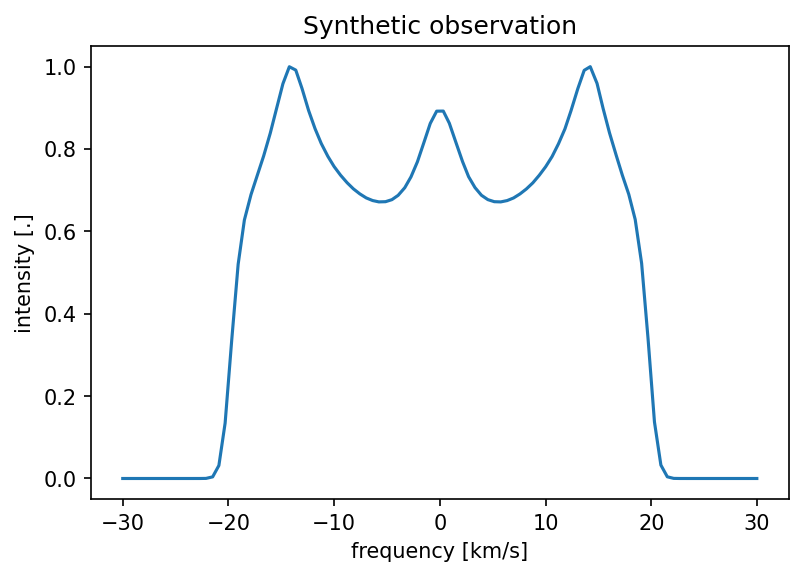

In [7]:
plt.figure(dpi=150)
plt.title("Synthetic observation")
plt.plot(velocities/1.0e+3, obs.data/obs.data.max())
plt.ylabel(r"intensity [.]")
plt.xlabel(r"frequency [km/s]")

## Fit
---

In [8]:
# def create_model():

#     model_1D = TensorModel(sizes=r_out, shape=n_elements)

#     r = model_1D.get_coords(origin=np.array([0]))
#     r[r<r_in] = r_in

#     v_min, v_max = v_in  , v_inf
#     n_min, n_max = 1.0e+1, 1.0e+2
#     T_min, T_max = 1.0e+1, 1.0e+3

#     # Define and initialise the model variables
#     model_1D['log_velocity'    ] = np.log(v_min + (v_max - v_min) * np.random.rand(n_elements))
#     model_1D['log_CO'          ] = np.log(n_min + (n_max - n_min) * np.random.rand(n_elements))
#     model_1D['log_temperature' ] = np.log(T_min + (T_max - T_min) * np.random.rand(n_elements))
#     model_1D['log_v_turbulence'] = np.log(v_turb) * np.ones_like(r)

#     # Explicitly set all model variables free (i.e. all will be fitted) except the turbulence
#     model_1D.free_all()
#     model_1D.fix('log_temperature' )
#     model_1D.fix('log_v_turbulence')

#     # Create a spherically symmetric model form the 1D TensorModel
#     spherical = SphericallySymmetric(model_1D)

#     return spherical

In [9]:

#     # Create a spherically symmetric model form the 1D TensorModel
#     spherical = SphericallySymmetric(model_1D)

#     # Extract the projection cosine along the line of sight
#     direction = spherical.model_2D.get_radial_direction(origin=spherical.origin_2D)[0]
#     direction = direction.nan_to_num()

#     loss = Loss(['rep', 'reg', 'cnt', 'tmp'])
# # loss = Loss(['rep', 'reg', 'cnt'])

# spherical = create_model()

# spherical.plot()

In [10]:
1.0e-5*n_CO_max

33.3972565269875

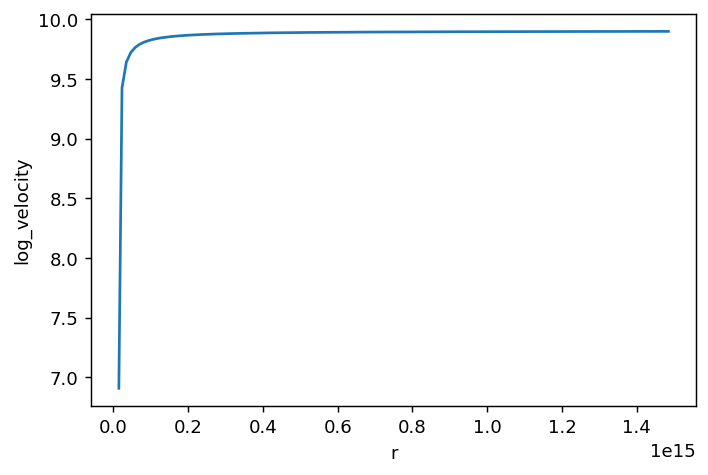

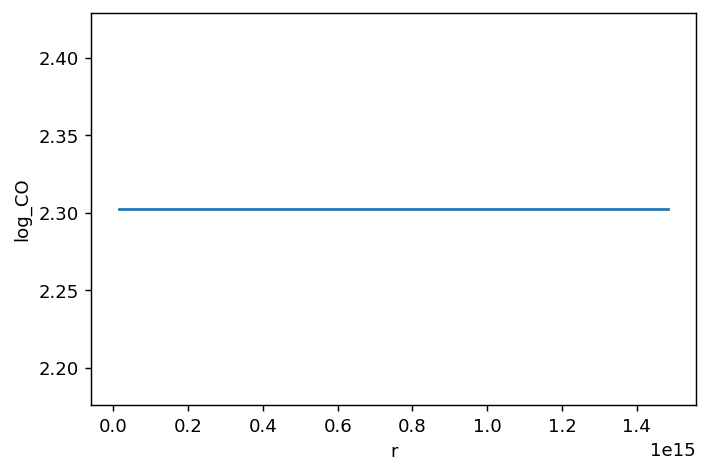

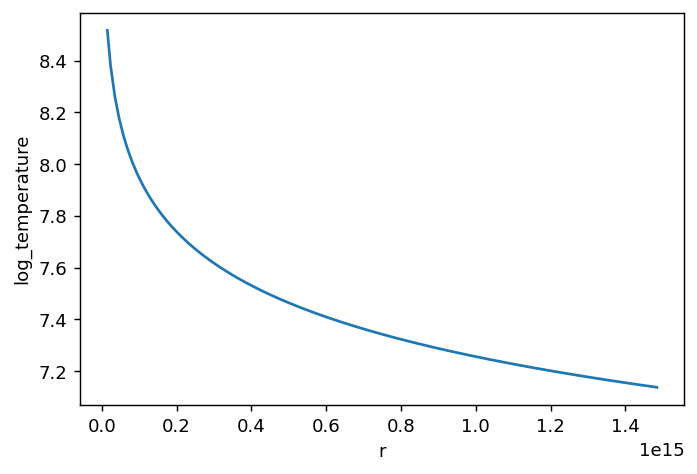

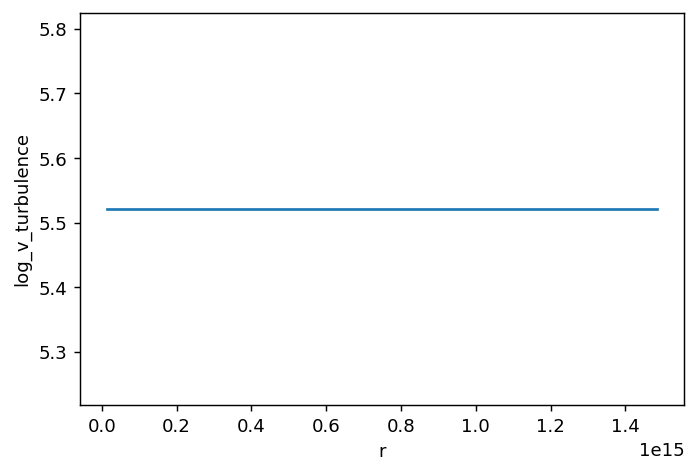

In [11]:
model_1D = TensorModel(sizes=r_out, shape=n_elements)

r = model_1D.get_coords(origin=np.array([0]))
r[r<r_in] = r_in

# Define and initialise the model variables
model_1D['log_velocity'    ] = np.log(   v(r)) #np.log(v_inf   ) * np.ones_like(r)
model_1D['log_CO'          ] = np.log(10) * np.ones_like(r) #np.log(1.0e-5*n_CO_max) * np.ones_like(r)
model_1D['log_temperature' ] = np.log(   T(r)) #np.log(T_in    ) * np.ones_like(r)
model_1D['log_v_turbulence'] = np.log(v_turb  ) * np.ones_like(r)

# Explicitly set all model variables free (i.e. all will be fitted) except the turbulence
model_1D.free_all()
model_1D.fix('log_velocity' )
model_1D.fix('log_temperature' )
model_1D.fix('log_v_turbulence')

# Create a spherically symmetric model form the 1D TensorModel
spherical = SphericallySymmetric(model_1D)

# Extract the projection cosine along the line of sight
direction = spherical.model_2D.get_radial_direction(origin=spherical.origin_2D)[0]
direction = direction.nan_to_num()

# loss = Loss(['rep', 'reg', 'cnt', 'tmp'])
# loss = Loss(['rep', 'cnt', 'tmp'])
# loss = Loss(['rep', 'reg', 'cnt'])
loss = Loss(['rep', 'reg'])

spherical.plot()

Text(0.5, 0, 'frequency [km/s]')

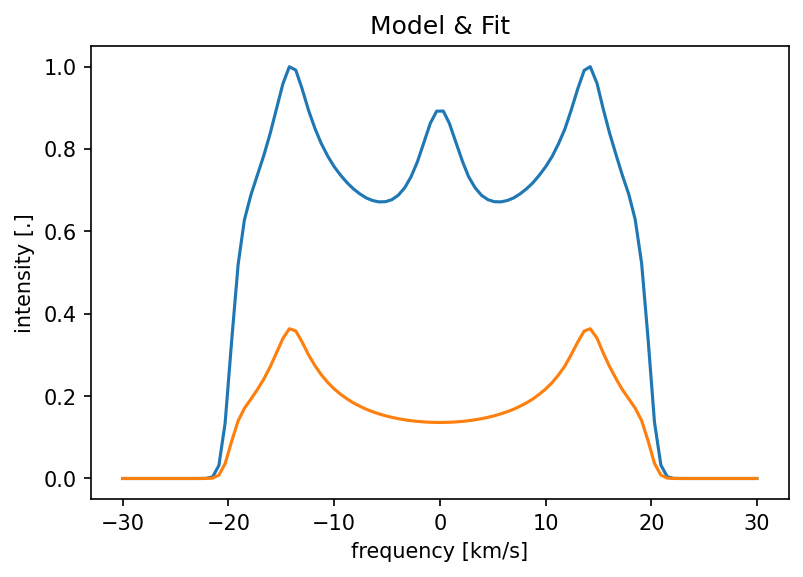

In [12]:
I = forward(spherical)

plt.figure(dpi=150)
plt.title("Model & Fit")
plt.plot(velocities/1.0e+3, obs.data/obs.data.max())
plt.plot(velocities/1.0e+3,   I.data/obs.data.max())
plt.ylabel(r"intensity [.]")
plt.xlabel(r"frequency [km/s]")

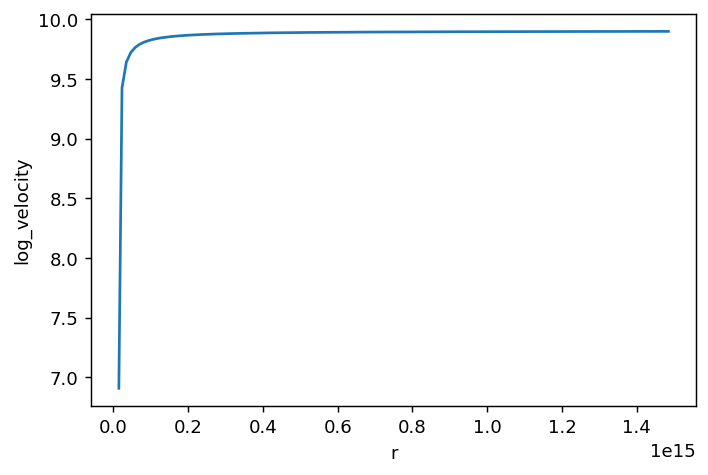

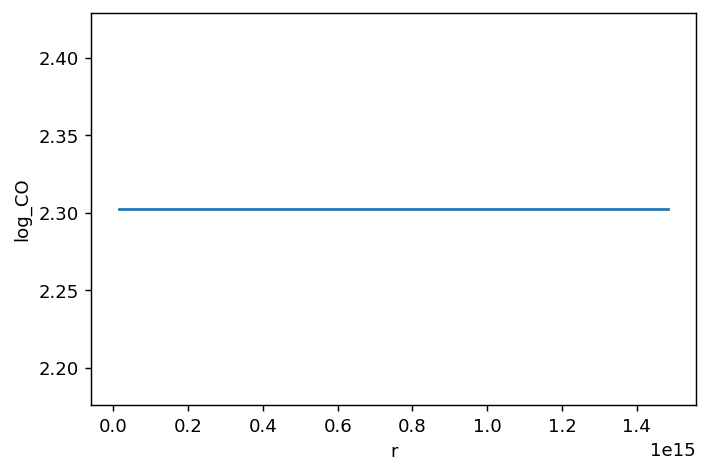

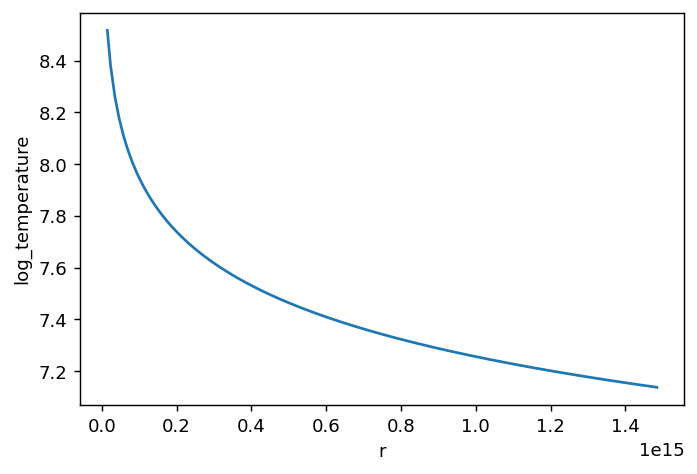

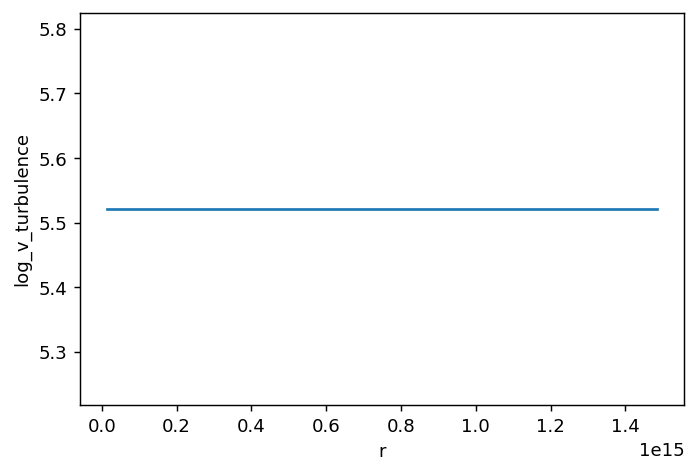

In [13]:
spherical.plot()

In [14]:
def steady_state_cont_loss(spherical, r):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    log_rho = spherical.model_1D['log_CO']
    log_v_r = spherical.model_1D['log_velocity']

    rho = torch.exp(log_rho)         
    v_r = torch.exp(log_v_r)
    
    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = spherical.model_1D.diff_x(r**2 * rho * v_r)

    # Compute the mean squared losses
    loss = torch.mean((loss_cont/((r**2)*rho))**2)

    # Return losses
    return loss

In [15]:
def steady_state_heat_loss(spherical, r):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    log_tmp = spherical.model_1D['log_temperature']

    # Heat equation (steady state): div(ρ v) = 0
    loss_heat = r * spherical.model_1D.diff_x(r * spherical.model_1D.diff_x(log_tmp))

    # Compute the mean squared losses
    loss = torch.mean(loss_heat**2)

    # Return losses
    return loss

In [16]:
def fit(loss, spherical, obs, N_epochs=100, lr=1.0e-1, w_rep=1.0, w_reg=1.0, w_cnt=1.0, w_tmp=1.0):

    optimizer = Adam(spherical.model_1D.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        I = forward(spherical)
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * torch.nn.functional.mse_loss(I, obs)
        # Compute the regularisation loss
        loss['reg'] = w_reg * spherical.model_1D.apply(diff_loss)
        # Compute the hydrodynamic loss
        # loss['cnt'] = w_cnt * steady_state_cont_loss(spherical, torch.from_numpy(r))    
        # loss['tmp'] = w_tmp * steady_state_heat_loss(spherical, torch.from_numpy(r))    

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

    return I

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


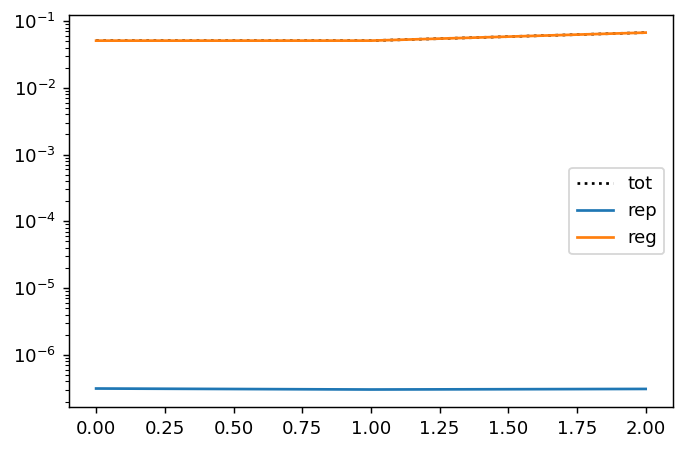

In [17]:
I = fit(loss, spherical, obs, N_epochs=3, lr=1.0e-1, w_reg=1.0)
loss.plot()

In [18]:
loss.renormalise_all()
loss.reset()

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


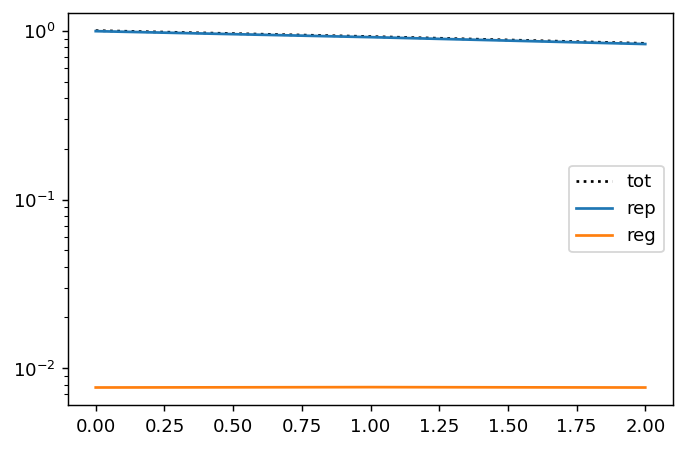

In [19]:
I = fit(loss, spherical, obs, N_epochs=3, lr=1.0e-1, w_reg=1.0e-2)
loss.plot()

100%|██████████| 500/500 [06:51<00:00,  1.22it/s]


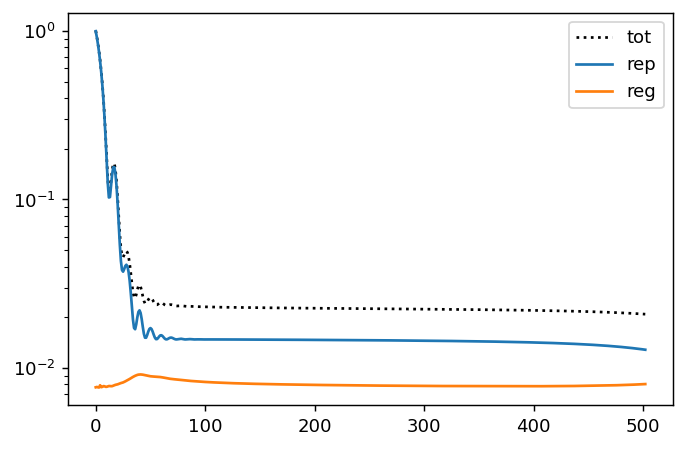

In [20]:
I = fit(loss, spherical, obs, N_epochs=500, lr=1.0e-1, w_reg=1.0e-2)
loss.plot()

100%|██████████| 200/200 [04:33<00:00,  1.37s/it]


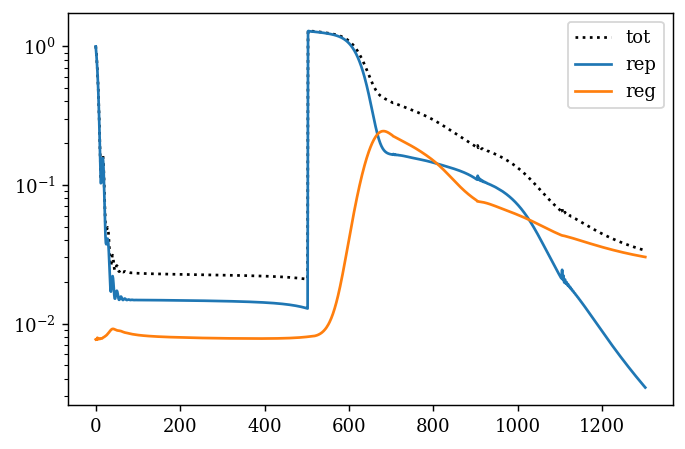

In [30]:
I = fit(loss, spherical, obs, N_epochs=200, lr=1.0e-2, w_rep=1.0e+2, w_reg=1.0e-2)
loss.plot()

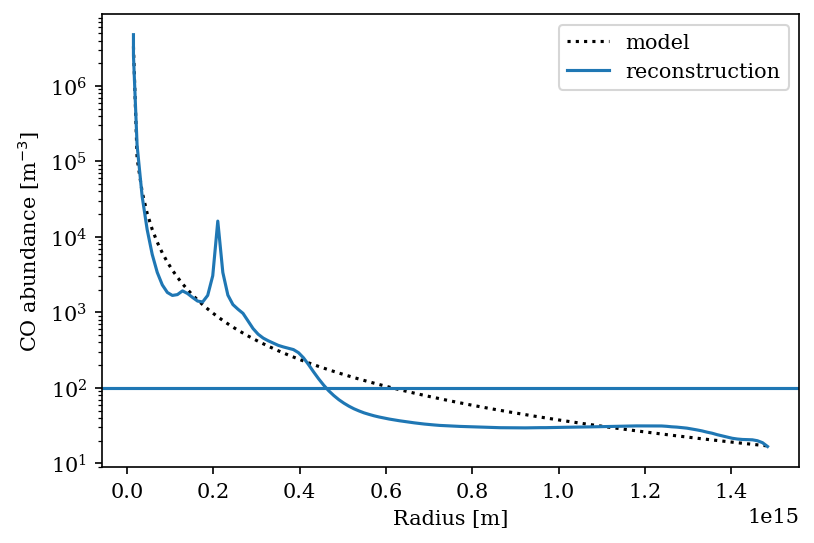

In [31]:
plt.rcParams["font.family"] = "serif"
plt.figure(dpi=150)
plt.plot(r, n_CO(r), c='k', linestyle=':', label='model')
plt.axhline(100)
plt.plot(r, torch.exp(spherical.model_1D['log_CO']).data, label='reconstruction')
plt.yscale('log')
plt.ylabel('CO abundance [m$^{-3}$]')
plt.xlabel('Radius [m]')
plt.legend()

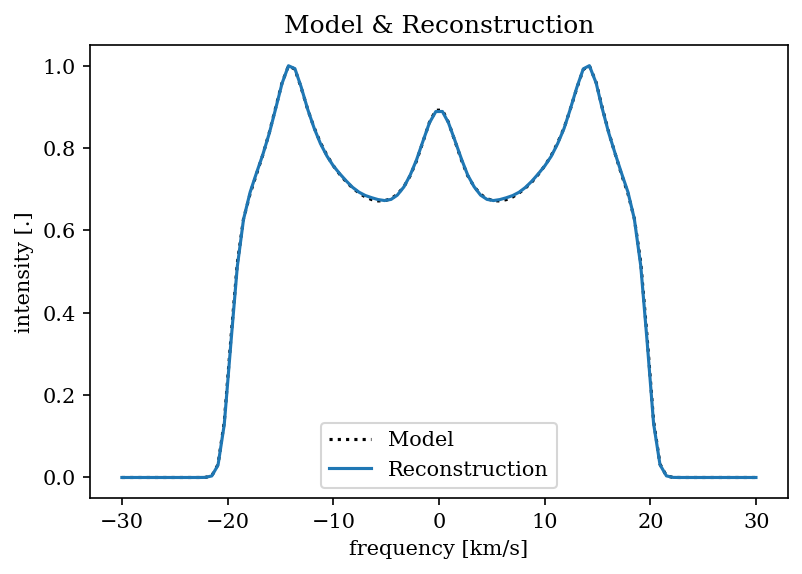

In [32]:
I = forward(spherical)

plt.figure(dpi=150)
plt.title("Model & Reconstruction")
plt.plot(velocities/1.0e+3, obs.data/obs.data.max(), c='k', linestyle=':', label='Model')
plt.plot(velocities/1.0e+3,   I.data/obs.data.max(),                       label='Reconstruction')
plt.ylabel(r"intensity [.]")
plt.xlabel(r"frequency [km/s]")
plt.legend()

In [33]:
spherical.model_1D.save('spherical_only_CO_3.h5')

In [17]:
spherical.model_1D = spherical.model_1D.load('spherical_only_CO.h5')
spherical.map_1D_to_2D()

In [60]:
spherical.model_1D['log_CO'].data += 2*torch.rand_like(spherical.model_1D['log_CO'])

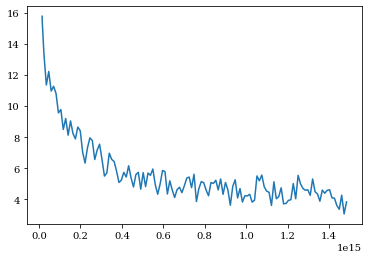

In [59]:
plt.plot(r, (spherical.model_1D['log_CO'] + 2*torch.rand_like(spherical.model_1D['log_CO'])).data, label='reconstruction')

100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


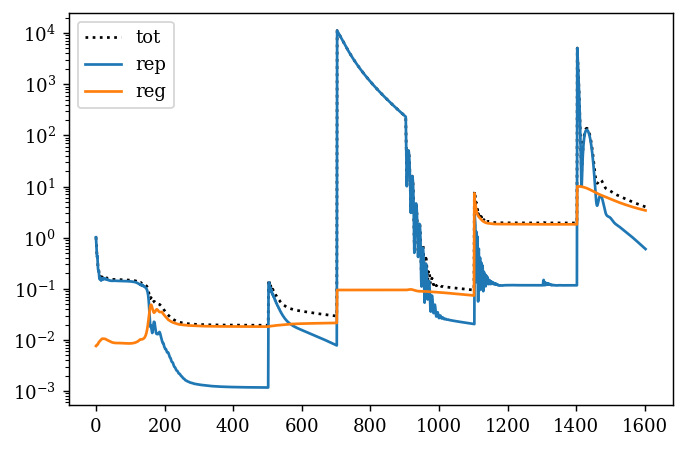

In [61]:
I = fit(loss, spherical, obs, N_epochs=200, lr=1.0e-1, w_rep=1.0e+2, w_reg=1.0e+0)
loss.plot()

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


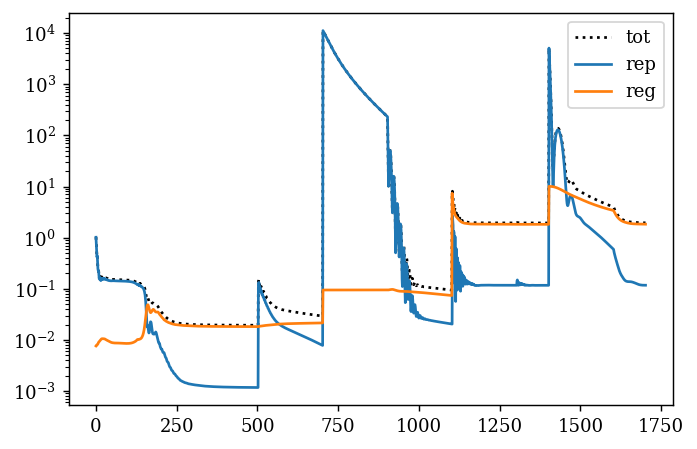

In [62]:
I = fit(loss, spherical, obs, N_epochs=100, lr=1.0e-2, w_rep=1.0e+2, w_reg=1.0e+0)
loss.plot()

In [70]:
loss.renormalise_all()
loss.reset()

100%|██████████| 300/300 [02:48<00:00,  1.78it/s]


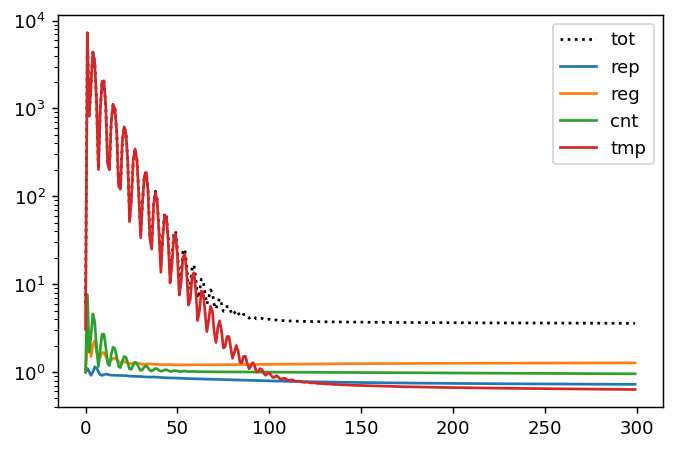

In [71]:
I = fit(loss, spherical, obs, N_epochs=300, lr=2.0e-2)
loss.plot()

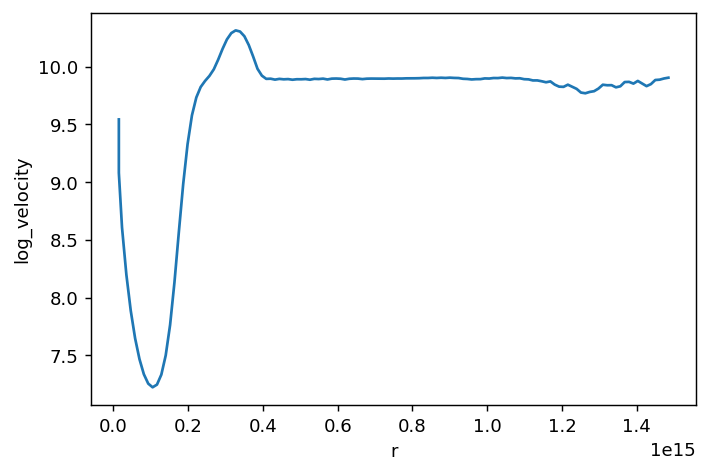

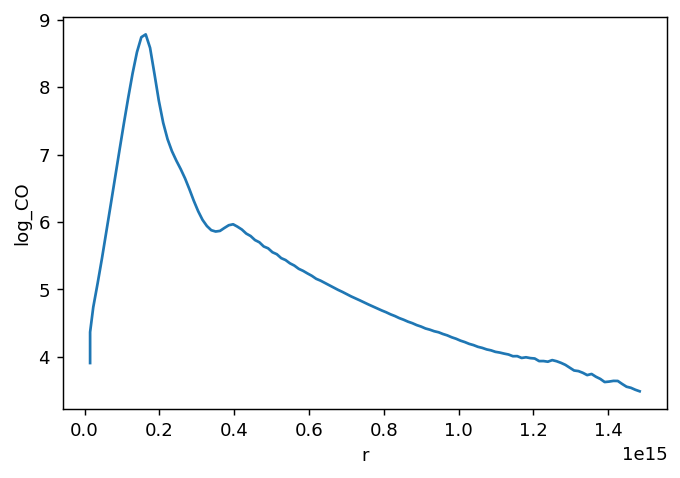

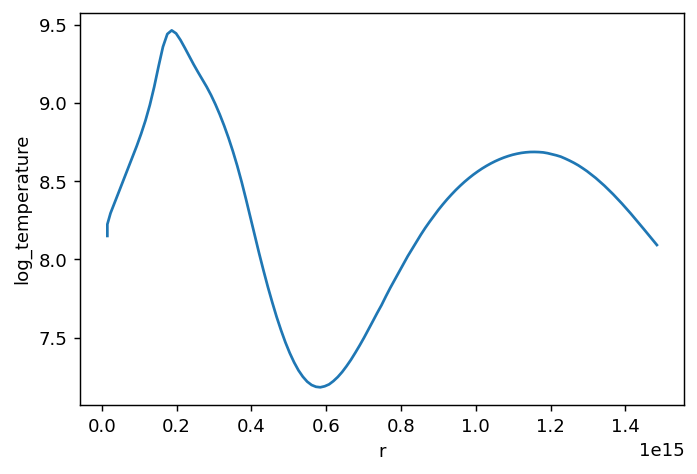

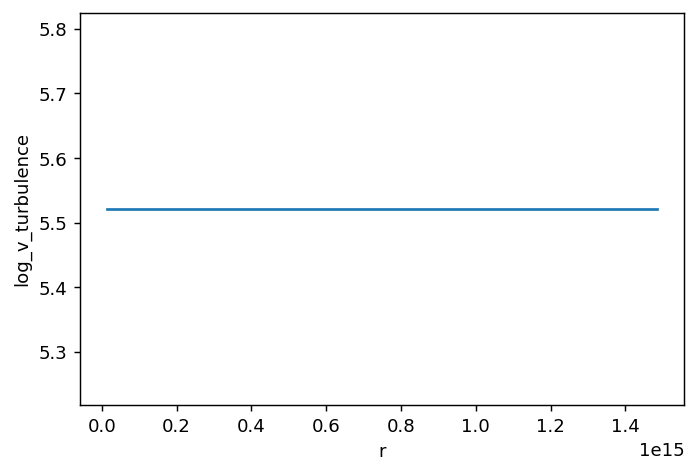

In [52]:
spherical.plot()

Text(0.5, 0, 'frequency [km/s]')

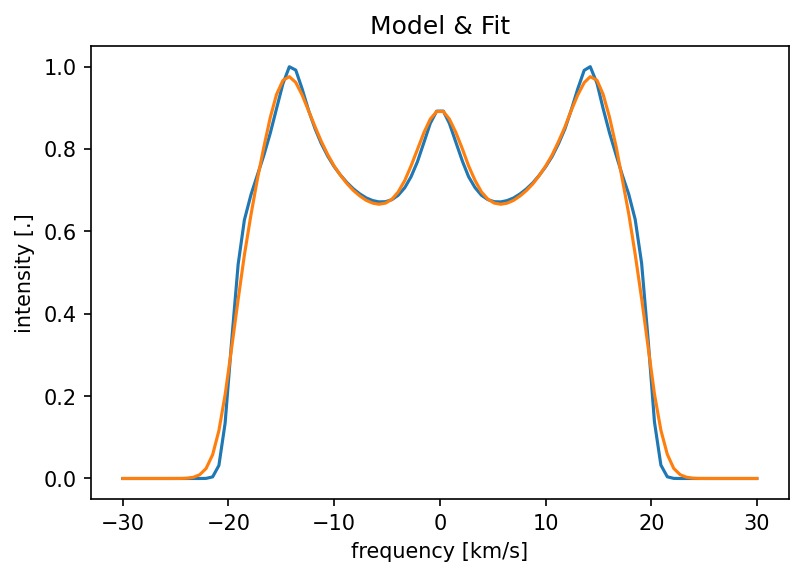

In [65]:
plt.figure(dpi=150)
plt.title("Model & Fit")
plt.plot(velocities/1.0e+3, obs.data/obs.data.max())
plt.plot(velocities/1.0e+3,   I.data/obs.data.max())
plt.ylabel(r"intensity [.]")
plt.xlabel(r"frequency [km/s]")
# plt.yscale('log')